# Fine-Tuning para Detecção de Emoções com FER2013 usando MobileNetV2

In [4]:
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [5]:
# Inicio do treinamento
start_time = time.time()

In [6]:
!python3 /content/dataset_prepare.py

Saving images...
100% 35887/35887 [01:20<00:00, 448.15it/s]
Done!


In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [9]:
# Configuração do TensorBoard
# Diretório de logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
gpus = tf.config.list_physical_devices("GPU")
print("GPUs disponíveis:", gpus)

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# Caminhos
train_dir = './data/train'
val_dir = './data/test'

In [12]:
# Hiperparâmetros
img_size = 96  # MobileNetV2 exige >=96x96
batch_size = 64
num_epochs = 30
num_classes = 7

In [13]:
# Preprocessamento dos dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

In [14]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.


In [16]:
# Exibição de classes
print("Classes disponíveis:", train_generator.class_indices)

Classes disponíveis: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


In [17]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 7178 images belonging to 7 classes.


In [18]:
import ssl
import certifi
try:
    ssl._create_default_https_context = ssl.create_default_context(cafile=certifi.where())
except Exception as e:
    print("Certificado SSL não pode ser configurado:", e)


In [19]:
# Carregando o modelo base
base_model = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_96_no_top.h5'
)

In [20]:
# Head personalizada
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [21]:
# Compilando
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
# Treinamento inicial com backbone congelado
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    callbacks=[early_stop, tensorboard_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 170s 270ms/step - accuracy: 0.2845 - loss: 2.0861 - val_accuracy: 0.3550 - val_loss: 2.9924
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 95s 212ms/step - accuracy: 0.4494 - loss: 1.4326 - val_accuracy: 0.4634 - val_loss: 2.0780
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 93s 208ms/step - accuracy: 0.5135 - loss: 1.2741 - val_accuracy: 0.5226 - val_loss: 1.5842
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 95s 211ms/step - accuracy: 0.5498 - loss: 1.1945 - val_accuracy: 0.5347 - val_loss: 1.4784
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.5680 - loss: 1.1345 - val_accuracy: 0.5663 - val_loss: 1.2327
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 93s 207ms/step - accuracy: 0.5908 - loss: 1.0836 - val_accuracy: 0.5773 - val_loss: 1.1815
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 97s 215ms/step - accuracy: 0.6012 - loss: 1.0538 - val_accuracy: 0.5883 - val_loss: 1.1295
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 97s 217ms/step - accuracy: 0.6233 - loss: 

In [23]:
# Salvando o modelo
model.save('mobilenetv2_emotion_finetuned_v2.keras')

In [24]:
# Fim do treinamento
end_time = time.time()

In [25]:
# Cálculo do tempo total em segundos
training_time = end_time - start_time

In [26]:
training_time

2882.8298799991608

In [27]:
# Convertendo para horas, minutos e segundos
hours = training_time // 3600
minutes = (training_time % 3600) // 60
seconds = (training_time % 3600) % 60

print(f"Tempo total de treinamento: {int(hours)}h {int(minutes)}m {int(seconds)}s")

Tempo total de treinamento: 0h 48m 2s


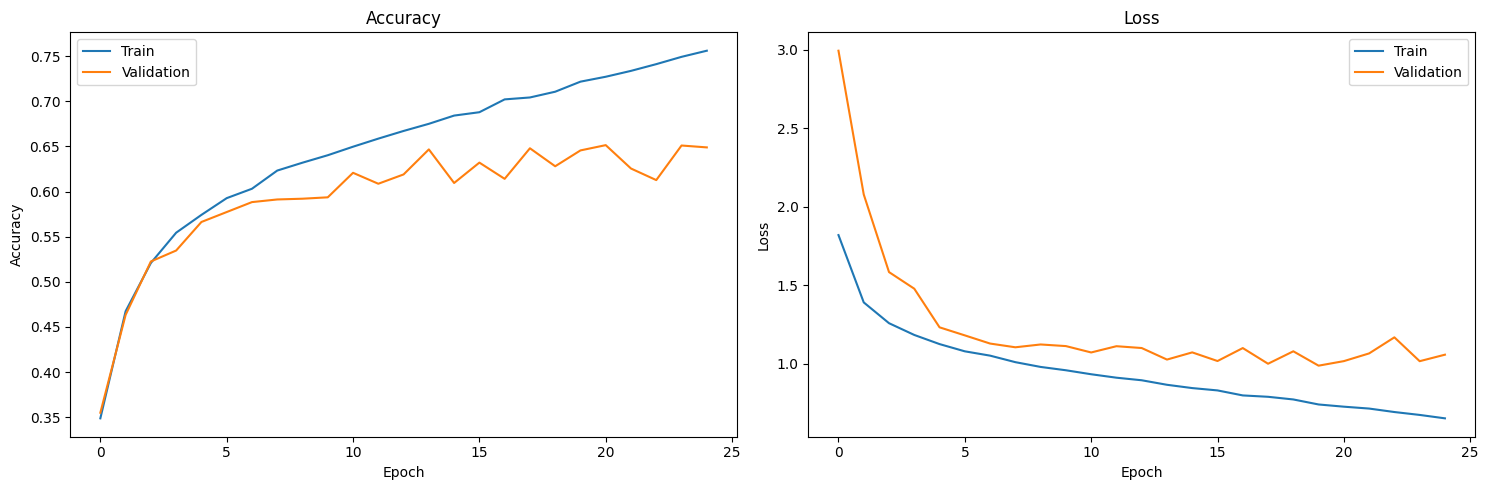

In [28]:
# Função para plotar histórico
def plot_model_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(history.history['accuracy'], label='Train')
    axs[0].plot(history.history['val_accuracy'], label='Validation')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    axs[1].plot(history.history['loss'], label='Train')
    axs[1].plot(history.history['val_loss'], label='Validation')
    axs[1].set_title('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

plot_model_history(history)

In [29]:
# Acurácia final no conjunto de treinamento
train_accuracy = history.history['accuracy'][-1]

# Acurácia final no conjunto de validação
val_accuracy = history.history['val_accuracy'][-1]

print(f"Acurácia no conjunto de treinamento: {train_accuracy * 100:.2f}%")
print(f"Acurácia no conjunto de validação: {val_accuracy * 100:.2f}%")


Acurácia no conjunto de treinamento: 75.60%
Acurácia no conjunto de validação: 64.89%


In [30]:
# Exibir todas as acurácias por epoch
for epoch, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy']), 1):
    print(f"Epoch {epoch}: Treinamento: {train_acc * 100:.2f}%, Validação: {val_acc * 100:.2f}%")

Epoch 1: Treinamento: 34.88%, Validação: 35.50%
Epoch 2: Treinamento: 46.74%, Validação: 46.34%
Epoch 3: Treinamento: 52.09%, Validação: 52.26%
Epoch 4: Treinamento: 55.44%, Validação: 53.47%
Epoch 5: Treinamento: 57.42%, Validação: 56.63%
Epoch 6: Treinamento: 59.27%, Validação: 57.73%
Epoch 7: Treinamento: 60.31%, Validação: 58.83%
Epoch 8: Treinamento: 62.33%, Validação: 59.13%
Epoch 9: Treinamento: 63.20%, Validação: 59.21%
Epoch 10: Treinamento: 64.03%, Validação: 59.36%
Epoch 11: Treinamento: 64.97%, Validação: 62.08%
Epoch 12: Treinamento: 65.86%, Validação: 60.87%
Epoch 13: Treinamento: 66.71%, Validação: 61.90%
Epoch 14: Treinamento: 67.50%, Validação: 64.67%
Epoch 15: Treinamento: 68.42%, Validação: 60.95%
Epoch 16: Treinamento: 68.79%, Validação: 63.21%
Epoch 17: Treinamento: 70.21%, Validação: 61.41%
Epoch 18: Treinamento: 70.42%, Validação: 64.80%
Epoch 19: Treinamento: 71.06%, Validação: 62.80%
Epoch 20: Treinamento: 72.18%, Validação: 64.56%
Epoch 21: Treinamento: 72.72%

## Visualizando os Métricos no TensorBoard
Para iniciar o TensorBoard, execute o seguinte comando no terminal:

```bash
tensorboard --logdir=logs/fit
```

Depois, acesse o endereço fornecido pelo TensorBoard no navegador para visualizar os gráficos e métricas.

In [ ]:
%tensorboard --logdir logs/fit

In [2]:
%tensorboard --logdir=logs/fit --port=6006

# Salvar os arquivos local

/Logs

In [ ]:
!zip -r /content/logs.zip /content/logs
from google.colab import files
files.download("/content/logs.zip")

/model

In [ ]:
!zip -r /content/mobilenetv2_emotion_finetuned_v2.keras.zip /content/mobilenetv2_emotion_finetuned_v2.keras
from google.colab import files
files.download("/content/mobilenetv2_emotion_finetuned_v2.keras.zip")

  adding: content/mobilenetv2_emotion_finetuned_07-05.keras (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>